In [1]:
# General import
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
%matplotlib inline
# Local import
from Codes.dataprocess import DataGen
from Codes.dataprocess import Export_ep
from Codes.algoviolet import violetBD
from Codes.display import Display_ker
from Codes.display import Display_im
from Codes.display import Display_epd
from Codes.myfunc import nablah
from Codes.myfunc import convolve
from Codes.simplex import Simplex

# Minimisation fonction bi-convexe concave

On introduit le probleme d'optimisation biconvex-concave
de déconvolution aveugle d'images 
avec l' a priori de noyau de convolution régulier,

$$
\underset{u \in U ,K \in \Sigma}{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \gamma \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

L'espace $\Sigma$ correspond à l'ensemble des simplexes 
(ensemble des noyaux à coefficient positif dont la somme des coefficients vaut 1).
Par extension on notera $\Sigma$ la fonction indicatrice de cet ensemble.
L'espace $U$ correspond à l'hypercube $[0,1]^{N_x \times N_y}$, ou la boule unité pour la norme $L^\infty$.
Sa fonction indicatrice correspond donc à $\chi_{B,1}$.

La fonction à minimiser peut alors se réécrire

$$
\underset{u ,K }{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2}\gamma \| g - K * u\|^2 
+ \chi_{B,1} (u)
+ \frac{1}{2} \alpha \| D K \|^2
+ \Sigma(K)
+\langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

On note

$$
L =\frac{1}{2} \gamma \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
$$

Pour résoudre ce probleme d'optimisation on se propose de tester l'algorithme suivant,

$$
\left\{
\begin{align}
& K_{k+1} = \text{prox}_{\Sigma} \; (K_k - \gamma \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; )\\
& \tilde{u}_{k+1} = \text{proj}_{B_1} \; (u_k - \tau \partial_u L(u_k,K_k,v_k) \; )\\
& v_{k+1}         = \text{prox}_{B_\mu} \; (v_k + \sigma \partial_v L (u_{k+1},K_{k+1},v_k) \; )\\
& u_{k+1} = \tilde{u}_{k+1} + \theta_u (\tilde{u}_{k+1} - u_k) \quad \text{(relaxation)}
\end{align}
\right.
$$

Question :
est-ce qu'on met une relaxation aussi sur $K$ ?

$$
K_{k+1} = \tilde{K}_{k+1} + \theta_K (\tilde{K}_{k+1} - K_k)  \quad \text{(relaxation aussi ?)}
$$

On écrit alors les dérivées partielles de $L$,

$$
\left\{
\begin{align}
& \partial_u L(u_k,K_k,v_k) \; ) = \text{div} \cdot v_k - \tilde{K} * (g-K*u)\\
& \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; ) = - (g-K*u)*\tilde{u} + \alpha D^TDK \\
& \partial_v L (u_{k+1},K_{k+1},v_k) \; ) =  \nabla u
\end{align}
\right.
$$

On trace les énergies primales et duales au cours de la minimisation

$$
\left\{
\begin{align}
& Ep = \frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \mu. \text{TV} (u) \\
\\
& Ed = - \langle \nabla u ,v \rangle - \chi_{B,\mu}(v)
\end{align}
\right.
$$

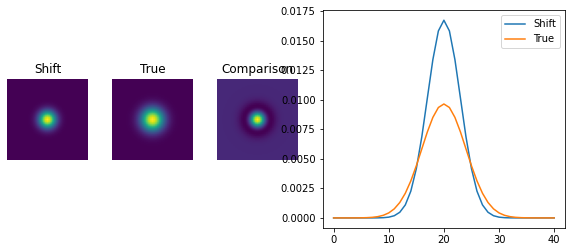

Erreur |Shift - True|/ |True| : 0.4667 


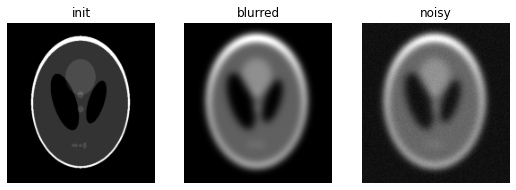

Erreur blurred |x_blurr- x_true|_2 :0.5786
Erreur |x_noisy - x_true|_2 :0.5800


In [2]:
K1, K2, x_im, x_b, x_o1 = DataGen()

## Initialisation noyau exact - pas de bruit

In [6]:
alpha     = 0.0
mu        = 0.001
K_in      = K1.copy()
x_in      = x_im.copy()
K_out,x_out,Ep22,Ed22 = violetBD(K_in,x_in,x_b,alpha,mu,\
                            niter=10000,coeffK=0.0,coeffx=1,\
                            proj_simplex=True)

iteration 60 %--- gradient K 14.1023 --- gradient x 0.0647
iteration 120 %--- gradient K 20.3942 --- gradient x 0.1477
iteration 180 %--- gradient K 22.6668 --- gradient x 0.1581
iteration 240 %--- gradient K 27.0436 --- gradient x 0.1579
iteration 300 %--- gradient K 31.7762 --- gradient x 0.1582
iteration 360 %--- gradient K 35.0962 --- gradient x 0.1577
iteration 420 %--- gradient K 38.0512 --- gradient x 0.1568
iteration 480 %--- gradient K 40.9657 --- gradient x 0.1559
iteration 540 %--- gradient K 43.8187 --- gradient x 0.1557
iteration 600 %--- gradient K 46.1372 --- gradient x 0.1503
iteration 660 %--- gradient K 48.8634 --- gradient x 0.1501
iteration 720 %--- gradient K 50.7297 --- gradient x 0.1519
iteration 780 %--- gradient K 51.9648 --- gradient x 0.1538
iteration 840 %--- gradient K 53.3632 --- gradient x 0.1520
iteration 900 %--- gradient K 55.0910 --- gradient x 0.1503
iteration 960 %--- gradient K 56.9100 --- gradient x 0.1477
iteration 1020 %--- gradient K 58.8964 --

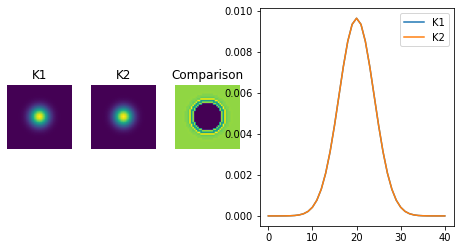

Erreur |K1 - K2|/ |K2| : 0.0000 


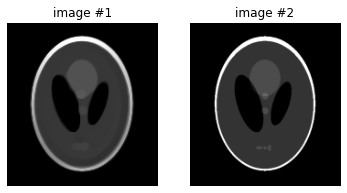

Erreur |im1 - im2|/|im2| :0.2735


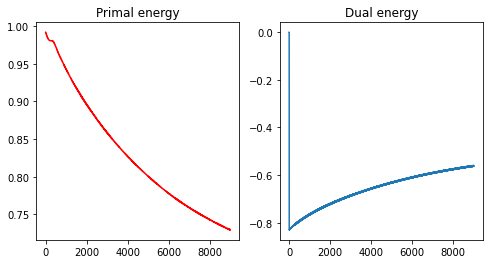

In [7]:
Display_ker(K_out,K_in,mysize=(8,4))
Display_im(x_out,x_im,mysize=(6,3))
Display_epd(Ep22,Ed22)

## Initialisation du noyau exacte - bruit std 0.05

Les erreurs initiales sont

$$
\begin{cases}
e_K = 0 \\
e_x = 0.2577
\end{cases}
$$

In [8]:
alpha = 0.001
mu    = 0.005
K_in   = K1.copy()
x_in  = x_o1
K_out,x_out,Ep21,Ed21 = violetBD(K_in,x_in,x_b,alpha,mu,\
                            niter=3000,coeffK=0.001,coeffx=0.1,\
                            proj_simplex=True)
# (1/tau_u - Lf) = sqrt(8)
# tau_v = coeff_v1/sqrt(8)
# tau_k = coeff_K*2/L_total
# (1/tau_u - Lf)1/tau_v <8

iteration 60 %--- gradient K 1204.4486 --- gradient x 2.0990
iteration 120 %--- gradient K 1385.5190 --- gradient x 1.6581
iteration 180 %--- gradient K 1386.3290 --- gradient x 1.4330
iteration 240 %--- gradient K 1331.7262 --- gradient x 1.2821
iteration 300 %--- gradient K 1256.8917 --- gradient x 1.1692
iteration 360 %--- gradient K 1180.7042 --- gradient x 1.0822
iteration 420 %--- gradient K 1109.3088 --- gradient x 1.0133
iteration 480 %--- gradient K 1043.7198 --- gradient x 0.9534
iteration 540 %--- gradient K 986.0096 --- gradient x 0.9026
iteration 600 %--- gradient K 935.8220 --- gradient x 0.8599
iteration 660 %--- gradient K 892.7081 --- gradient x 0.8240
iteration 720 %--- gradient K 852.7620 --- gradient x 0.7902
iteration 780 %--- gradient K 817.5339 --- gradient x 0.7611
iteration 840 %--- gradient K 786.0968 --- gradient x 0.7348
iteration 900 %--- gradient K 757.3614 --- gradient x 0.7102
iteration 960 %--- gradient K 731.0652 --- gradient x 0.6880
iteration 1020 %-

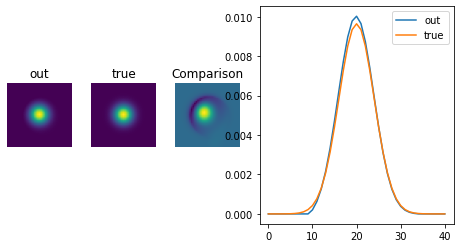

Erreur |out - true|/ |true| : 0.0541 


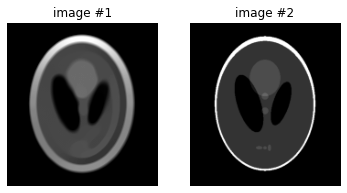

Erreur |im1 - im2|/|im2| :0.4902


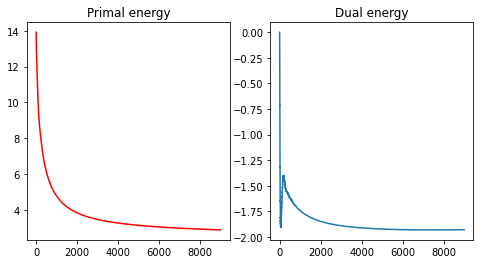

In [9]:
Display_ker(K_out,K_in,mysize=(8,4),label1='out',label2='true')
Display_im(x_out,x_im,mysize=(6,3))
Display_epd(Ep21,Ed21)

In [10]:
# Export_ep(Ep21,label='2',cas='1')

## Initialisation noyau proche - bruit std 0.05
Les erreurs initiales sont

$$
\begin{cases}
e_K=0.2811 \\
e_x=0.2724
\end{cases}
$$

In [9]:
alpha     = 0.01
mu        = 0.01
K_in      = K2.copy()
x_in      = np.zeros(x_im.shape)
K_out,x_out,Ep23,Ed23 = violetBD(K_in,x_in,x_o1,\
                            alpha,mu,coeffK=0.001,coeffx=0.1,\
                            niter=3000,\
                            proj_simplex=True)

iteration 60 %--- gradient K 13644.1334 --- gradient x 10.1585
iteration 120 %--- gradient K 6181.3963 --- gradient x 4.2554
iteration 180 %--- gradient K 2021.0702 --- gradient x 2.1963
iteration 240 %--- gradient K 599.3595 --- gradient x 1.4602
iteration 300 %--- gradient K 553.9079 --- gradient x 1.1254
iteration 360 %--- gradient K 594.4131 --- gradient x 0.9173
iteration 420 %--- gradient K 556.4142 --- gradient x 0.7713
iteration 480 %--- gradient K 489.6867 --- gradient x 0.6566
iteration 540 %--- gradient K 423.0147 --- gradient x 0.5758
iteration 600 %--- gradient K 364.2104 --- gradient x 0.5060
iteration 660 %--- gradient K 314.4446 --- gradient x 0.4534
iteration 720 %--- gradient K 273.0779 --- gradient x 0.4143
iteration 780 %--- gradient K 239.2655 --- gradient x 0.3746
iteration 840 %--- gradient K 211.9646 --- gradient x 0.3492
iteration 900 %--- gradient K 189.5276 --- gradient x 0.3241
iteration 960 %--- gradient K 171.0649 --- gradient x 0.2998
iteration 1020 %--- 

In [10]:
#Export_ep(Ep23,label='2',cas='3')

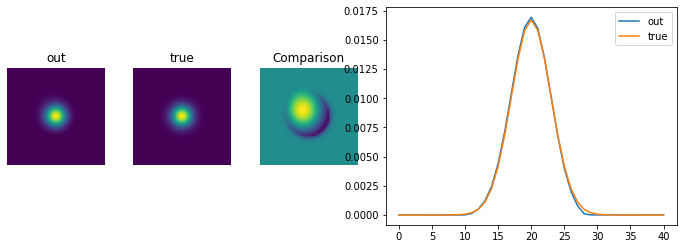

Erreur |out - true|/ |true| : 0.0413 


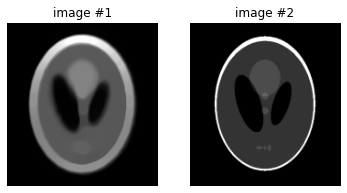

Erreur |im1 - im2|/|im2| :0.5475


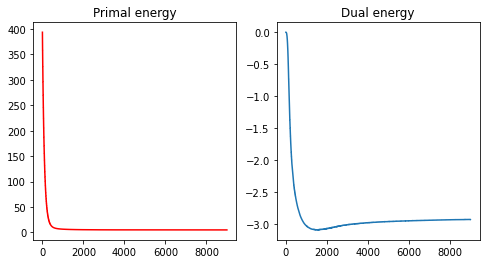

In [11]:
Display_ker(K_out,K_in,mysize=(12,4),label1='out',label2='true')
Display_im(x_out,x_im,mysize=(6,3))
Display_epd(Ep23,Ed23)